In [52]:
import numpy as np
import pandas as pd
import scipy.stats as S
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Tuple, List

# 2.1

Simulate random and uniform distance point in term of

In [53]:
def g(w: np.array) -> int:
    """
    quadratic equation w**2 centered at 0
    :param w:
    :return:
    """
    r = np.matmul(np.transpose(w), w)
    return r

def simulate(N, P, lb=-1, ub=1) -> List[Tuple[int, int, int]]:
    # range -1, 1 for each dim
    result = []
    dims = []
    for n in range(1, N+1):
        lowest = min([g(np.random.uniform(lb, ub, n)) for _ in range(P)])
        result.append(lowest)
        dims.append(n)
    return list(zip(result, dims, [P]*N))

def simulate2(N, P, lb=-1, ub=1) -> List[Tuple[int, int, int]]:
    # range -1, 1 for each dim
    result = []
    dims = []
    for n in range(1, N+1):
        lowest = min([g(2*np.random.rand(n)-1) for _ in range(P)])
        result.append(lowest)
        dims.append(n)
    return list(zip(result, dims, [P]*N))

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_49002/4166031284.py:15: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(df1, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[0])
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_49002/4166031284.py:17: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.lineplot(df2, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[1])


Text(0.5, 1.0, '1-100 Dimensions plot with various samples')

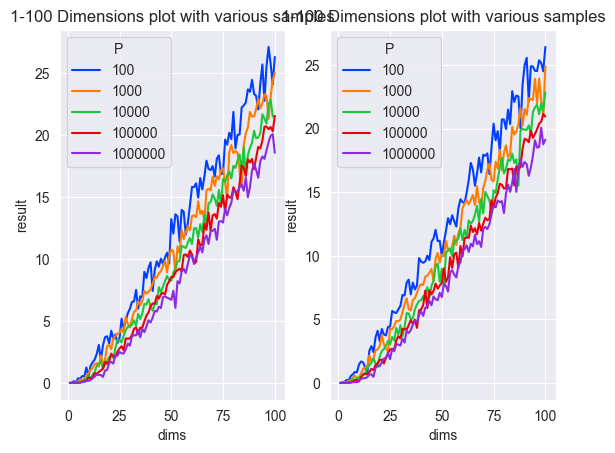

In [60]:
"""
trend seen uniform:
as p gets higher, the resulting minimum value attained is lower.

unsure part: not sure if uniform vs random is uniform sample or do i have to do
hypercube + llyod optimization sampling or just do a formal set
"""
set_1 = []
for p in range(2,7):
    set_1.extend(simulate(100, 10**p))
df1 = pd.DataFrame(set_1, columns=['result', 'dims', 'P'])
set_2 = []
for p in range(2,7):
    set_2.extend(simulate(100, 10**p))
df2 = pd.DataFrame(set_2, columns=['result', 'dims', 'P'])
fig, axes = plt.subplots(nrows=1, ncols=2)
sns.lineplot(df1, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[0])
axes[0].set_title('1-100 Dimensions plot with various samples')
sns.lineplot(df2, x='dims', y='result', hue='P', palette=sns.color_palette("bright"), ax=axes[1])
axes[1].set_title('1-100 Dimensions plot with various samples')

# 2.2

implementation of random search algorithm
1. take in a vector
2. create set of direction vectors according to P, direction vectors should have a length of 1
3. walk in the best direction
4. repeat the process K times


In [ ]:
def create_direction_random(w: np.array, P=1000) -> List[np.array]:
    pass